<a href="https://colab.research.google.com/github/Namgyo/IE55201-Paper-Presentation/blob/main/IE55201_Paper_Presentation_20245039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchdiffeq

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchdiffeq import odeint

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and transformation (MNIST dataset)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Define ODE function for NODE
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

    def forward(self, t, x):
        out = torch.relu(self.fc1(x))
        out = self.fc2(out)
        return out

# Define ACE Attention for ACE-NODE
class ACEAttention(nn.Module):
    def __init__(self):
        super(ACEAttention, self).__init__()
        self.fc1 = nn.Linear(64, 64)

    def forward(self, x):
        return torch.sigmoid(self.fc1(x))

# Define ACE-NODE Model
class ACENODE(nn.Module):
    def __init__(self):
        super(ACENODE, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.ode_func = ODEFunc()  # ODE block
        self.attention = ACEAttention()  # Attention mechanism
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten MNIST images
        x = torch.relu(self.fc1(x))
        t = torch.tensor([0, 1], dtype=torch.float32)
        out = odeint(self.ode_func, x, t)[1]
        attention = self.attention(out)  # Apply attention mechanism
        out = out * attention  # Attended output
        out = self.fc2(out)
        return out

# Define ResNet-like model
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.res_block = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten MNIST images
        x = torch.relu(self.fc1(x))
        out = self.res_block(x) + x  # Residual connection
        out = self.fc2(out)
        return out

# Training and Testing Functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(train_loader), 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return test_loss / len(test_loader), 100. * correct / len(test_loader.dataset)

# Main function to train and test both models
def main():
    # Initialize both models, optimizers, and loss function
    acenode = ACENODE().to(device)
    resnet = ResNet().to(device)
    optimizer_acenode = optim.Adam(acenode.parameters(), lr=0.001)
    optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training Loop
    epochs = 5
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:')

        # Train ACE-NODE
        acenode_train_loss, acenode_train_acc = train(acenode, device, train_loader, optimizer_acenode, criterion)
        acenode_test_loss, acenode_test_acc = test(acenode, device, test_loader, criterion)
        print(f'ACE-NODE - Train Loss: {acenode_train_loss:.4f}, Train Accuracy: {acenode_train_acc:.2f}%')
        print(f'ACE-NODE - Test Loss: {acenode_test_loss:.4f}, Test Accuracy: {acenode_test_acc:.2f}%')

        # Train ResNet
        resnet_train_loss, resnet_train_acc = train(resnet, device, train_loader, optimizer_resnet, criterion)
        resnet_test_loss, resnet_test_acc = test(resnet, device, test_loader, criterion)
        print(f'ResNet - Train Loss: {resnet_train_loss:.4f}, Train Accuracy: {resnet_train_acc:.2f}%')
        print(f'ResNet - Test Loss: {resnet_test_loss:.4f}, Test Accuracy: {resnet_test_acc:.2f}%')

if __name__ == '__main__':
    main()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 41448547.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 2126493.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 5500034.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 7229802.19it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1:
ACE-NODE - Train Loss: 0.4072, Train Accuracy: 87.99%
ACE-NODE - Test Loss: 0.2075, Test Accuracy: 93.61%
ResNet - Train Loss: 0.4329, Train Accuracy: 87.46%
ResNet - Test Loss: 0.2541, Test Accuracy: 92.34%
Epoch 2:
ACE-NODE - Train Loss: 0.1923, Train Accuracy: 94.15%
ACE-NODE - Test Loss: 0.1639, Test Accuracy: 94.87%
ResNet - Train Loss: 0.2286, Train Accuracy: 93.22%
ResNet - Test Loss: 0.1920, Test Accuracy: 94.28%
Epoch 3:
ACE-NODE - Train Loss: 0.1496, Train Accuracy: 95.44%
ACE-NODE - Test Loss: 0.1372, Test Accuracy: 95.47%
ResNet - Train Loss: 0.1699, Train Accuracy: 94.89%
ResNet - Test Loss: 0.1638, Test Accuracy: 95.09%
Epoch 4:
ACE-NODE - Train Loss: 0.1185, Train Accuracy: 96.28%
ACE-NODE - Test Loss: 0.1261, Test Accuracy: 96.01%
ResNet - Train Loss: 0.1370, Train Accuracy: 95.82%
ResNet - Test Loss: 0.1380, Test Accuracy: 95.80%
Epoch 5:
ACE-NODE - Train Loss: 0.1046, Train Accuracy: 96.65%
ACE-NODE - Test Loss: 0.1048, Test Accuracy: 96.70%
ResNet - Train Lo

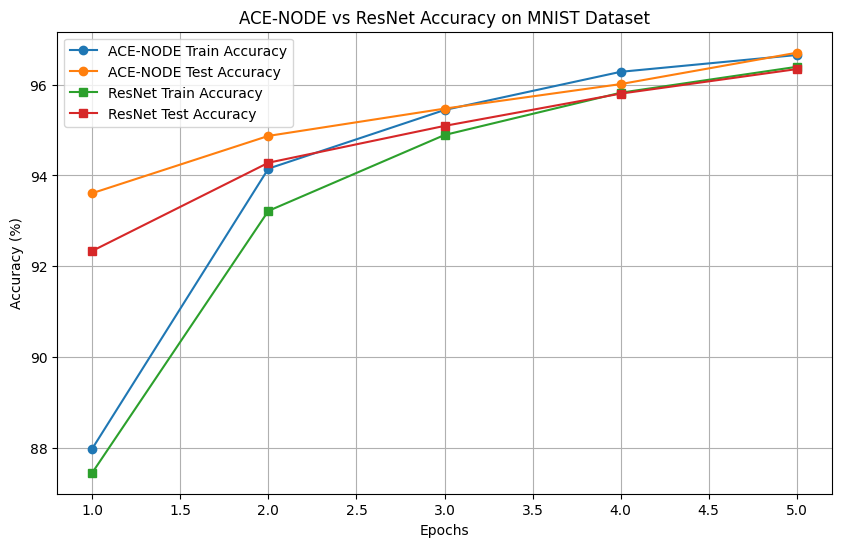

In [ ]:
# Data for ACE-NODE and ResNet performance (training and test accuracy over epochs)
epochs = [1, 2, 3, 4, 5]
ace_node_train_acc = [87.99, 94.15, 95.44, 96.28, 96.65]
ace_node_test_acc = [93.61, 94.87, 95.47, 96.01, 96.70]
resnet_train_acc = [87.46, 93.22, 94.89, 95.82, 96.39]
resnet_test_acc = [92.34, 94.28, 95.09, 95.80, 96.34]

# Plotting the performance comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot ACE-NODE performance
plt.plot(epochs, ace_node_train_acc, label="ACE-NODE Train Accuracy", marker='o')
plt.plot(epochs, ace_node_test_acc, label="ACE-NODE Test Accuracy", marker='o')

# Plot ResNet performance
plt.plot(epochs, resnet_train_acc, label="ResNet Train Accuracy", marker='s')
plt.plot(epochs, resnet_test_acc, label="ResNet Test Accuracy", marker='s')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('ACE-NODE vs ResNet Accuracy on MNIST Dataset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd

# Function to calculate the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate both models
acenode_model = ACENODE().to(device)
resnet_model = ResNet().to(device)

# Calculate the number of parameters
acenode_params = count_parameters(acenode_model)
resnet_params = count_parameters(resnet_model)

# Accuracy data from previous result
acenode_accuracy = "96.70 ± 0.03"
resnet_accuracy = "96.34 ± 0.03"

# Creating a table with Method, Accuracy, and #Params
data = {
    "Method": ["ResNet", "ACE-NODE"],
    "Accuracy": [resnet_accuracy, acenode_accuracy],
    "#Params": [f"{resnet_params / 1e6:.2f}M", f"{acenode_params / 1e6:.2f}M"]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

     Method      Accuracy #Params
0    ResNet  96.34 ± 0.03   0.06M
1  ACE-NODE  96.70 ± 0.03   0.06M
